In [3]:
# A script demonstrating measurement and analysis of Energy Proxy Traits..
# Oli Tills
# 29/04/2021

!pip install scikit-image
!pip install numpy
!pip install vuba
!pip install wget
!pip install matplotlib
!pip install opencv-python
!pip install tqdm
!pip install tsne
!pip install plotnine
!pip install zenodo-get

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=44d413cffc43a25cca54ba7f77ebc3a563f72212c164cc490f589892d23871f0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 552kB 7.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tsne: filename=tsne-0.3.1-cp37-cp37m-linux_x86_64.whl size=260486 sha256=990ad73352e84c79968a71c1c9b4a7c6d2b87a768da76c6879dabcc47e482af5
  Stored in directory: /root/.cache/pip/wheels/3e/d6/fc/58392f18ea8fc4c74e20185d2faeee87a1c1924a182606c6cd
Successfully built tsne


In [9]:
import math
import skimage
import numpy
import vuba
import urllib.request
import wget
import numpy as np
import cv2
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, facet_grid

def download_zenodo_video(path = False):
    if not path:
        print('Downloading...')
        vid = wget.download('https://zenodo.org/record/4645805/files/20C_A1_10d.avi?download=1')
        print('Download complete')
    else:
        print('Downloading...')
        vid = wget.download(path)
        print('Download complete')

def calculate_epts(video, frame_rate = 15, resolution = 8, visuals=True):
    if resolution not in [2,4,6,8]:
        raise ValueError('Resolution for blockwise frequencies  -'
                         'must be 1,2,4 or 8 (default)')

    mean_px_vals = _runNestedMeanWindowCalc(video, frame_rate, resolution)

    ept_out = _freq_analysis(mean_px_vals, frame_rate, resolution)
    if visuals:
        visualise_mean_px_vals(mean_px_vals, resolution)
        visualise_ept_spectra(ept_out, resolution)

    return ept_out

def _runNestedMeanWindowCalc(video, frame_rate, resolution):
    #cap = cv2.VideoCapture(video)
    print('Calculating mean pixel values...')
    video = vuba.Video(video)
    x = video.width
        #cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    y = video.height
        #cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    # Check image resolution is divisible by the blockwise resolution and if not
    # reduce the image size via cropping marginally
    expand_x = int(x%resolution)
    expand_y = int(y%resolution)
    if (expand_x-x)%resolution != 0:
        expand_x = resolution - expand_x
    if (expand_y-y)%resolution != 0:
        expand_y = resolution - expand_y

    fc = int(len(video))
    frames = video.read(start=0, stop=fc)
        #cap.get(cv2.CAP_PROP_FRAME_COUNT)
    if resolution == 1:
        mean_px_vals = np.zeros((fc, resolution))
        mean_px_vals[:] = np.NaN
    else:
        mean_px_vals = np.zeros((fc, resolution, resolution))
        mean_px_vals[:] = np.NaN

    with tqdm(total=len(frames)) as pb:
        f = 0
        for frame in frames:
            #_, im = cap.read()
            #im = cap.read(f)
            im = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            im = np.ascontiguousarray(im)

            if resolution == 1:
                # First get overall embryoBB mean
                mean_px_vals[f,:,:] = im.mean()

            else:
                if expand_x == 0 and expand_y == 0:
                    mean_px_vals[f,:,:] = skimage.util.view_as_blocks(im,
                                                      block_shape=(int(im.shape[0] / resolution),
                                                                   int(im.shape[1] / resolution))).mean(axis=(2,3))

                if expand_x !=0 and expand_y !=0:
                    mean_px_vals[f,:,:] = skimage.util.view_as_blocks(im[expand_y:im.shape[0],
                                                      expand_x:im.shape[1]],
                                                      block_shape=(int((im.shape[0]-expand_y)/ resolution),
                                                                   int((im.shape[1]-expand_x)/ resolution))).mean(axis=(2,3))

                elif expand_x != 0:
                    mean_px_vals[f,:,:] = skimage.util.view_as_blocks(im[:,expand_x:im.shape[0]],
                                                      block_shape=(int((im.shape[0] -expand_y)/ resolution),
                                                                   int(im.shape[1] / resolution))).mean(axis=(2,3))

                elif expand_y != 0:
                    mean_px_vals[f,:,:] = skimage.util.view_as_blocks(im[expand_y:im.shape[0],:],
                                                      block_shape=(int((im.shape[0] -expand_y)/ resolution),
                                                                   int(im.shape[1] / resolution))).mean(axis=(2,3))
            f = f + 1
            pb.update(1)
    return mean_px_vals

def _freq_analysis(mean_px_vals, frame_rate, resolution):
    # Calculating energy proxy trait spectra...
    # Get necessary info..
    samp_freqs, power_spect = signal.welch(mean_px_vals[:,0,0],
                                         frame_rate,
                                         scaling='spectrum',
                                         nfft=len(mean_px_vals))
    # Arrays for output
    if resolution ==1:
        # Output array
        epts = np.zeros((2,len(power_spect)))
        epts[0,:], epts[1,:] = signal.welch(mean_px_vals,frame_rate, scaling='spectrum', nfft=mean_px_vals.shape)

    else:
        # Output array
        epts = np.zeros((resolution,resolution,2,len(power_spect)))
        # Create and run meshgrids to prevent need for nested loops..
        X,Y = np.meshgrid(range(resolution),range(resolution))
        X = X.flatten()
        Y = Y.flatten()

        for b in range(resolution*resolution):
            epts[X[b],Y[b],0,:], epts[X[b],Y[b],1,:] = signal.welch(mean_px_vals[:,X[b],Y[b]],frame_rate, scaling='spectrum', nfft=len(mean_px_vals))

    # Return numpy arrays in a dict for unpacking.
    return epts

def visualise_mean_px_vals(mean_px, resolution):
    fig, axs = plt.subplots(resolution, resolution, sharex=True)
    fig.subplots_adjust(left=0.08, right=0.98, wspace=0.1)
    X, Y = np.meshgrid(range(resolution), range(resolution))
    X = X.flatten(); Y = Y.flatten()
    for b in range(resolution*resolution):
        ax = axs[X[b],Y[b]]
        ax.set_autoscale_on(True)
        ax.get_yaxis().set_visible(False)
        ax.plot(mean_px[:, X[b],Y[b]], linewidth=0.5)
        ax.relim
    fig.suptitle('Mean pixel values')
    fig.text(0.5, 0.04, 'Frame', ha='center')
    fig.text(0.04, 0.5, 'Mean pixel value (scaled independantly per block)', va='center', rotation='vertical')
    plt.show()


def visualise_ept_spectra(epts, resolution):
    fig, axs = plt.subplots(resolution, resolution, sharex=True)
    fig.subplots_adjust(left=0.08, right=0.98, wspace=0.1)
    X, Y = np.meshgrid(range(resolution), range(resolution))
    X = X.flatten(); Y = Y.flatten()
    for b in range(resolution*resolution):
        ax = axs[X[b],Y[b]]
        ax.set_autoscale_on(True)
        ax.get_yaxis().set_visible(False)
        ax.plot(epts[X[b],Y[b],0,:],
                np.log(epts[X[b],Y[b],1,:]), linewidth=0.5)
        ax.relim
    fig.suptitle('Energy proxy trait spectra')
    fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center')
    fig.text(0.04, 0.5, 'Energy', va='center', rotation='vertical')
    plt.show()

def download_zenodo_videos(path = False, num = 'all'):
    print('Downloading ')
    if not path:
        !zenodo_get 10.5281/zenodo.4645805
    #else:

def download_zenodo_video(path = False):
    if not path:
        print('Downloading...')
        vid = wget.download('https://zenodo.org/record/4645805/files/20C_A1_10d.avi?download=1')
        print('Download complete')
    else:
        print('Downloading...')
        vid = wget.download(path)
        print('Download complete')

def batch_analysis(vids):
    # Remove if not wanting to run this example
    vids = vids
    results = dict()
    temp = []
    time = []
    for v in range(len(vids)):
        print('Analysing: ', vids[v].split('.')[0])
        results[vids[v].split('.')[0]] = calculate_epts(vids[v], 30, 8)
        temp.append(vids[v].split('_')[0].split('C')[0])
        time.append(vids[v].split('_')[2].split('d')[0])
    # Integrate EPT data..
    keys = list(results.keys())
    out = np.zeros((len(vids), 301))
    for k in range(len(keys)):
        out[k, :] = np.mean(results[keys[k]][:, :, 1, :], axis=(0, 1))
    return out, temp, time

def dimensionality_reduction(out, temp, time):
    scaler = StandardScaler()
    # scaler.fit(out)
    out = scaler.fit_transform(np.log(out + 1))

    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(np.log(out + 1))

    # Run PCA and uMap
    pca = PCA(n_components=100).fit_transform(scaled.reshape(scaled.shape[0], 301))
    dim_reduced = TSNE(n_components=3).fit_transform(pca)

    dim_reduced = pd.DataFrame(dim_reduced)
    dim_reduced['Temperature'] = temp
    dim_reduced['DevStage'] = time
    dim_reduced.columns = ['one', 'two', 'three', 'Temperature', 'DevStage']

    (ggplot(out, aes('one', 'two', color='factor(DevStage)'))
     + geom_point(aes(size='three'), alpha=0.7)
     + facet_grid('Temperature ~ .')
     )


Downloading...


  6%|▌         | 34/600 [00:00<00:01, 333.68it/s]

Download complete
Calculating mean pixel values...


100%|██████████| 600/600 [00:01<00:00, 346.45it/s]


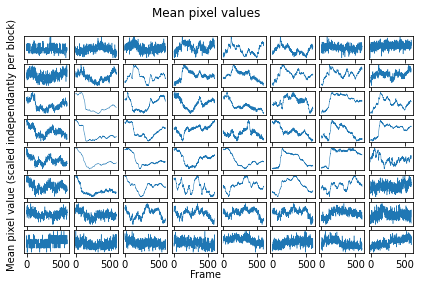

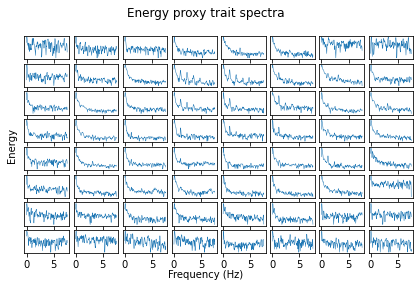

In [10]:
## Single video EPT example..
# Calculate EPTs for a single video..
download_zenodo_video()
vid = glob.glob('*.avi')[0]
epts = calculate_epts(video=vid)
